In [1]:
import sys
#sys.path.insert(0, '../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from pyDOE import lhs


np.random.seed(1234)
tf.set_random_seed(1234)

In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        #X_u, u: where to enforce value of u
        #X_f: where to enforce physics
        
        self.lb = lb
        self.ub = ub
    
        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u = u
        
        self.layers = layers
        self.nu = nu
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        

        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)         
        
        self.loss_u = tf.reduce_mean(tf.square(self.u_tf - self.u_pred))
        self.loss_f = tf.reduce_mean(tf.square(self.f_pred))
        self.loss = 1.*self.loss_u + 1.*self.loss_f               
                
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 100,
                                                                           'maxls': 100,
                                                                           'ftol' : 1 * np.finfo(float).eps})
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            
            #if (l%2==0):
            #    H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #else:
            #    H = tf.nn.leaky_relu(tf.add(tf.matmul(H, W), b))

            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        Y = tf.sigmoid(Y)
        return Y
            
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x,t):
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        #f = u_t + u*u_x - self.nu*u_xx #burger problem
        #f = u_t - 0.2*u_xx             #1D diffusion problem 
        #f = u_t - u_x                  #1D wave propagating left
        #f = u_t - u_x - 0.01*u_xx       #1D wave propagation with diffusion
        f = u_t + u_x                  #1D wave propagating right
        #f = u_t - (0.1+u)*u_x - self.nu*u_xx   #1D burger problem with diffusion
        return f
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self):
        
        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.u_tf: self.u,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        

    def predict(self, X_star):
                
        u_star = self.sess.run(self.u_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]})  
        f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
               
        return u_star, f_star

## Training Neural Net with Initial & Boundary Condition and Physics Laws

In [3]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 50
N_f = 200
#layers = [2, 20, 20, 20, 20, 1]
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 1]
#layers = [2, 4, 8, 16, 32, 64, 32, 16, 8, 4, 2, 1]

data = scipy.io.loadmat('../appendix/Data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #initial condition t=0
#uu1 = Exact[0:1,:].T
#uu1 = np.exp(-100*xx1[:,0:1]*xx1[:,0:1])
#uu1 = np.exp(-10*xx1[:,0:1]*xx1[:,0:1])*np.sin(xx1[:,0:1]*np.pi)
#uu1 = np.heaviside(xx1[:,0:1]-0.4,0) # shock wave
uu1 = np.zeros((xx1.shape[0],1)) #all zero

xx2 = np.hstack((X[:,0:1], T[:,0:1])) #boundary condition at x = -1
#uu2 = Exact[:,0:1]
uu2 = np.ones((xx2.shape[0],1))

xx3 = np.hstack((X[:,-1:], T[:,-1:])) #boundary condition at x = 1
uu3 = np.zeros((xx2.shape[0],1))
#uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
u_train = np.vstack([uu1, uu2, uu3])
#X_u_train = np.vstack([xx1])
#u_train = np.vstack([uu1])

In [4]:
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))


In [5]:
# select partial region to reinforce physics.
#X_f_train = np.array([X_f_train[i] for i in range(X_f_train.shape[0]) if ((X_f_train[i,1]<0.5) or (np.abs(X_f_train[i,0])<0.2))])
#X_f_train = np.array([X_f_train[i] for i in range(X_f_train.shape[0]) if (X_f_train[i,1]<0.2) or ((X_f_train[i,1]>0.7) and (X_f_train[i,1]<0.9))])

In [6]:
#idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
#X_u_train = X_u_train[idx, :]
#u_train = u_train[idx,:]

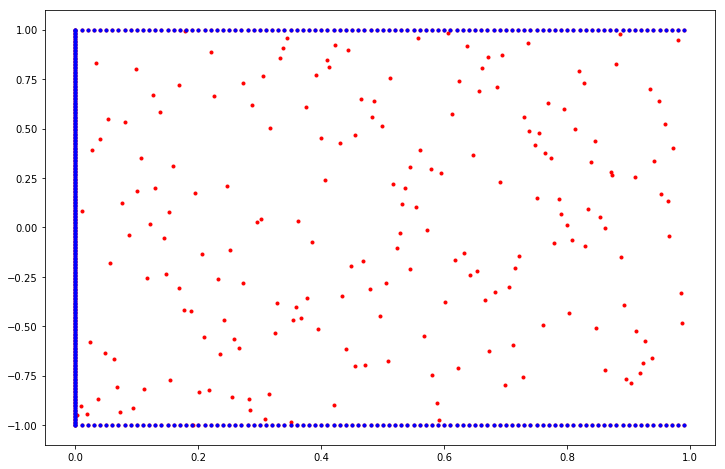

In [7]:
plt.figure(figsize=(12,8))
plt.plot(X_f_train[:,1],X_f_train[:,0],'r.')
plt.plot(X_u_train[:,1],X_u_train[:,0],'b.')


In [8]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

C:\Users\xiang.zhai\AppData\Local\Continuum\Miniconda2\envs\ML\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
start_time = time.time()                
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

Loss: 0.2621025
Loss: 0.16836607
Loss: 0.16088094
Loss: 0.15085311
Loss: 0.14870386
Loss: 0.3669735
Loss: 0.14386697
Loss: 0.1321934
Loss: 0.097446285
Loss: 0.46987823
Loss: 0.06922052
Loss: 0.05418512
Loss: 0.030888174
Loss: 0.024940826
Loss: 0.020289129
Loss: 0.0099114645
Loss: 0.008440414
Loss: 0.0065420475
Loss: 0.005281797
Loss: 0.0031434214
Loss: 0.0053158267
Loss: 0.001826987
Loss: 0.0021093518
Loss: 0.0016482249
Loss: 0.001642902
Loss: 0.0016156477
Loss: 0.0015759043
Loss: 0.0014543213
Loss: 0.001430635
Loss: 0.0014136741
Loss: 0.0013954887
Loss: 0.001335074
Loss: 0.0012122099
Loss: 0.001173069
Loss: 0.0011341198
Loss: 0.0011304396
Loss: 0.0011256787
Loss: 0.0011202348
Loss: 0.0011117364
Loss: 0.0011341765
Loss: 0.0011089336
Loss: 0.001105979
Loss: 0.0011044502
Loss: 0.0011036781
Loss: 0.001103087
Loss: 0.0011017505
Loss: 0.0011008986
Loss: 0.0011002392
Loss: 0.0011001861
Loss: 0.001103333
Loss: 0.0010999697
Loss: 0.0010997229
Loss: 0.001099362
Loss: 0.0010992419
Loss: 0.001099

In [10]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

Error u: 1.113379e+00


In [11]:
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

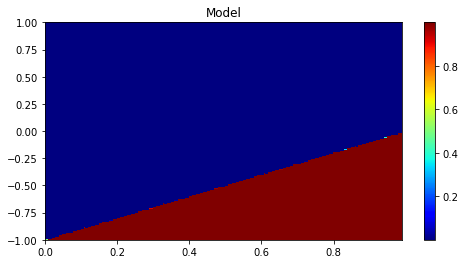

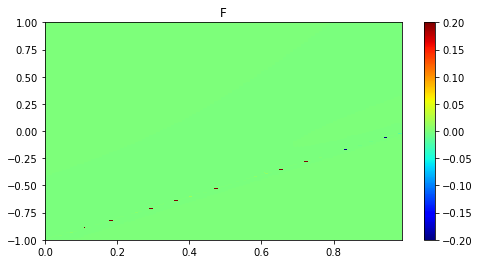

In [12]:
plt.figure(figsize=(8,4))
plt.pcolor(T, X, U_pred,cmap='jet')
plt.colorbar()
plt.title('Model')


plt.figure(figsize=(8,4))
plt.pcolor(T, X, F_pred,cmap='jet', vmin=-.2,vmax=.2)
plt.colorbar()
plt.title('F')



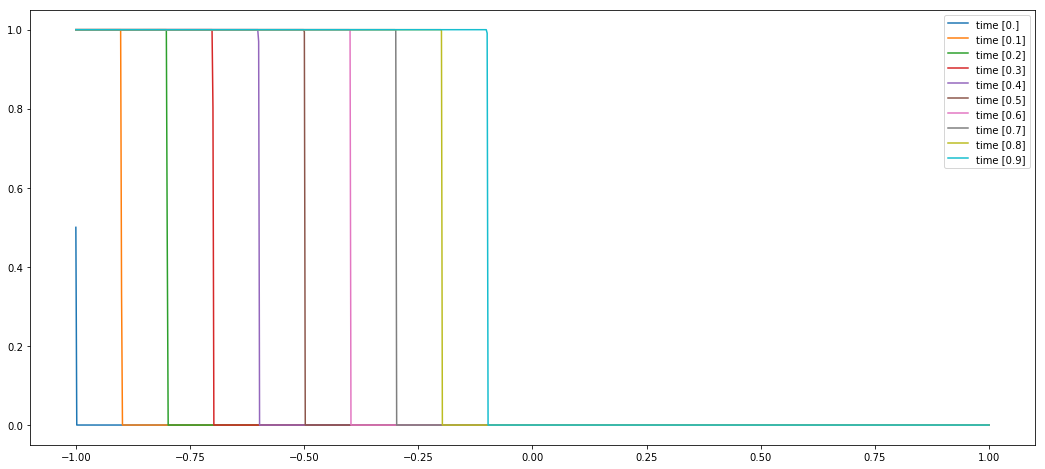

In [23]:
x = np.linspace(-1,1,1000).reshape(1000,1)
plt.figure(figsize=(18,8))
for tmp_i in range(0,t.shape[0],10):
    tmp_t = t[tmp_i]
    tmp_x_t = np.concatenate((x,np.full(x.shape,tmp_t)),1)
    tmp_u_pred, _ = model.predict(tmp_x_t)
    
    plt.plot(x,tmp_u_pred,label='time {}'.format(tmp_t))
    #plt.plot(Exact[tmp_i,:],':')
plt.legend()
    
# plt.figure(figsize=(12,8))
# for tmp_i in range(0,t.shape[0],10):
#     tmp_t = t[tmp_i]
#     tmp_u_pred = U_pred[tmp_i,:]
#     plt.plot(tmp_u_pred-Exact[0,:],label='t=%f' % tmp_t)
# plt.legend()


In [14]:
X_star_new = np.concatenate([X_star,X_star,X_star])
X_star_new[25600:,1]=X_star_new[25600:,1]+1
X_star_new[51200:,1]=X_star_new[51200:,1]+1

In [15]:
u_pred_new, f_pred_new = model.predict(X_star_new)
U_pred_new = np.reshape(u_pred_new,(len(t)*3,len(x)))


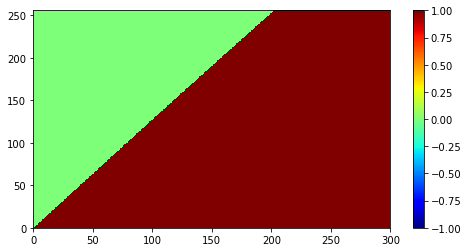

In [16]:
plt.figure(figsize=(8,4))
plt.pcolor(U_pred_new.T,cmap='jet', vmin=-1,vmax=1)
plt.colorbar()